<a href="https://colab.research.google.com/github/xihajun/Keep-learning/blob/master/code/cropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colab setup

In [3]:
import numpy as np
import pandas as pd

import os
import subprocess

import xml.etree.ElementTree as ElementTree
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack, vstack

import tensorflow as tf
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, UpSampling2D, Cropping2D
from keras.layers.normalization import BatchNormalization

from skimage import transform, data, io, filters, measure 
import pickle

import matplotlib.pyplot as plt

!pip install labelme

Using TensorFlow backend.


     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 62.2MB 126kB/s 
     |████████████████████████████████| 266kB 43.8MB/s 
  Created wheel for labelme: filename=labelme-3.16.7-cp36-none-any.whl size=1462722 sha256=1db18182e6aedd576fb34deb4521c8895ddd114ac4058046028ee8e37c1f4ea8
  Stored in directory: /root/.cache/pip/wheels/89/3d/a2/85c03378842deff05bbde6b22e9986484f01e36a728c013092
Successfully built labelme


## import google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("./drive/My Drive/")
os.chdir("./footwear_project")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## load files and images

In [0]:
imglist = []
for dirname, _, filenames in os.walk('./images'):
    for filename in filenames:
        imglist.append(os.path.join(dirname,filename))
    break

imglist = imglist[1:]

labellist = []
for dirname, _, filenames in os.walk('./footwear_mark'):
    for filename in filenames:
        labellist.append(os.path.join(dirname,filename))
    break

In [0]:
def ori_small_img(testingset):
  # load the training img
  img = plt.imread(testingset)
  (width,height,depth) = img.shape
  img = np.array(img.reshape((width,height,depth)))# / 255
  
  return img, transform.resize(img, (376,504))

In [0]:
# create a table to save the info
data = pd.DataFrame()
data['imglist'] = imglist

In [0]:
all_images = list(map(ori_small_img,imglist))

In [0]:
with open("all_img.pl",'wb') as f:
  pickle.dump(all_images,f)

In [0]:
with open("all_img.pl",'rb') as f:
  all_images = pickle.load(f)

In [0]:
ori = [image[0] for image in all_images]
images = [image[1] for image in all_images]

In [0]:
data['original_img'] = ori
data['small_img'] = images

# Neural Networks

## function clarification

In [0]:
def plot(array):
  plt.figure
  plt.imshow(array)

# plot(ruler_labels[0])

## data preparation 

In [0]:
ruler_labels = []
ruler_trainingsets = []
marker_labels = []
for i in range(len(labellist)):
    subprocess.run(["labelme_json_to_dataset", labellist[i],"-o","./test"])
    label = plt.imread("./test/label.png")
    # ruler_labels.append(label)
    label[:,:,0] = label[:,:,0]!=0
    label[:,:,1] = label[:,:,1]!=0
    ruler_labels.append(label)
    marker_labels.append(label[:,:,1])
    x = plt.imread("./test/img.png")
    x = np.delete(x, 3, axis = 2)
    ruler_trainingsets.append(x)

## define the model

In [22]:
(width,height,depth) = (376,504,3)

ruler_model = Sequential()

ruler_model.add(Conv2D(32,kernel_size = (2,2), 
                input_shape = (width,height,depth), 
                activation = 'relu',
                padding = 'same'))
ruler_model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

ruler_model.add(Conv2D(32,
                kernel_size = (2,2), 
                activation = 'relu',
                padding = 'same'))
ruler_model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

ruler_model.add(Conv2D(3,
                kernel_size = (2,2), 
                activation = 'sigmoid',
                padding = 'same'))
ruler_model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

ruler_model.add(UpSampling2D(size=(2, 2),
    data_format=None,
    interpolation='nearest'))

ruler_model.add(UpSampling2D(size=(2, 2),
    data_format=None,
    interpolation='nearest'))

ruler_model.add(UpSampling2D(size=(2, 2),
    data_format=None,
    interpolation='nearest'))

# ruler_model.add(Activation(activation='sigmoid'))
ruler_model.compile(optimizer='adam', loss='binary_crossentropy')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train the model

In [23]:
ruler_model.fit(np.array(ruler_trainingsets),np.array(ruler_labels).reshape(6,376,504,3),epochs=600)

Epoch 1/600



6/6 [==============================] - 9s 2s/step - loss: 0.7587
Epoch 2/600
6/6 [==============================] - 0s 7ms/step - loss: 0.7315
Epoch 3/600
6/6 [==============================] - 0s 6ms/step - loss: 0.7053
Epoch 4/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6808
Epoch 5/600
6/6 [==============================] - 0s 6ms/step - loss: 0.6588
Epoch 6/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6393
Epoch 7/600
6/6 [==============================] - 0s 6ms/step - loss: 0.6211
Epoch 8/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6025
Epoch 9/600
6/6 [==============================] - 0s 5ms/step - loss: 0.5837
Epoch 10/600
6/6 [==============================] - 0s 5ms/step - loss: 0.5644
Epoch 11/600
6/6 [==============================] - 0s 5ms/step - loss: 0.5450
Epoch 12/600
6/6 [==============================] - 0s 5ms/step - loss: 0.5265
Epoch 13/600
6/6 [==============================] - 0s 5ms/step - loss: 0.

## prediction

In [0]:
predictions = ruler_model.predict(np.array(images))
predictions_bw_img = [prediction[:,:,1].reshape(width,height) for prediction in predictions]
predictions_footwear_img = [prediction[:,:,0].reshape(width,height) for prediction in predictions]

# save into data
data['prediction'] = list(predictions)
data['predictions_ruler_marker'] = predictions_bw_img
data['predictions_footwear_img'] = predictions_footwear_img

# footwear image processing

## function defination

In [0]:
def test(a):
  sum_bag = [a[0]]
  k = 1
  for i in range(len(a)-1):
    # import pdb; pdb.set_trace()
    if a[i+1] != a[i] and a[i+1] == 1:
      k=-1*k
      sum_bag.append(sum_bag[i]+k*a[i])
    else:
      sum_bag.append(sum_bag[i]+k*a[i])
  return sum_bag

def test_m(a):
  sum_bag = [a[0]]
  k = 1
  for i in reversed(range(len(a)-1)):
    # import pdb; pdb.set_trace()
    if a[i+1] != a[i] and a[i+1] == 1:
      k=-1*k
      sum_bag.append(sum_bag[i]+k*a[i])
    else:
      sum_bag.append(sum_bag[i]+k*a[i])
  return sum_bag

In [0]:
def largeConnectComponent(bw_img):
    labeled_img, num = measure.label(bw_img, neighbors=8, background=0, return_num=True)
    max_label = []
    max_num = 0
    # import pdb; pdb.set_trace()
    for i in range(1, num+1):
        if np.sum(labeled_img == i) > 4000:
            max_num = np.sum(labeled_img == i)
            max_label.append(i)
    mcr = [(labeled_img == large_label) for large_label in max_label]
    if len(mcr) == 1:
      return np.array(mcr).reshape(376,504)
    else:
      return sum(mcr)

In [0]:
def largeConnectComponent_weak(bw_img):
    labeled_img, num = measure.label(bw_img, neighbors=8, background=0, return_num=True)
    max_label = []
    max_num = 0
    # import pdb; pdb.set_trace()
    for i in range(1, num+1):
        if np.sum(labeled_img == i) > 100:
            max_num = np.sum(labeled_img == i)
            max_label.append(i)
    mcr = [(labeled_img == large_label) for large_label in max_label]
    if len(mcr) == 1:
      return np.array(mcr).reshape(376,504)
    else:
      return sum(mcr)

In [0]:
def find_crop_loc(matrix):
    # matrix is the prediction as above
    # task: find the left point, right point, up point and down point
    d,r = matrix.shape
    u = 0
    for i in matrix:
        u+=1
        if sum(i)!=0:
            break
    for i in reversed(matrix):
        d-=1
        if sum(i)!=0:
            break 
    return u,d

In [0]:
def return_big_box(filtered_array):
  up,down = find_crop_loc(filtered_array)
  left,right = find_crop_loc(filtered_array.T)
  return (8*left,8*up,8*right,8*down)

## area selection

In [31]:
selected_areas = list(map(largeConnectComponent,np.rint(predictions_footwear_img)))
might_wrong = []
maker_length_all = []
for i in range(len(predictions_bw_img)):
  # plt.figure()
  # plt.imshow(images[i])
  find_loc = sum(predictions_bw_img[i].T)
  locations = np.where(find_loc >= max(find_loc))
  # col_start to col_end should be the marker 
  col_start = min(locations[0]) - 6
  col_end = max(locations[0]) + 6
  selected_marker_row = sum(predictions_bw_img[i][col_start:col_end])
  mean = np.mean(selected_marker_row)
  two_marker_loc = np.where(selected_marker_row>=mean)[0]
  # 两个连续的数列
  marker = range(min(two_marker_loc),max(two_marker_loc)+1)
  med = list(set(marker)-set(two_marker_loc))

  if len(med) == len(list(range(min(med),max(med)+1))):
    print("yes this should be the marker")
    maker_center = np.median(med)
    maker_length = max(two_marker_loc) - min(two_marker_loc)
    maker_width = maker_length/14
    might_wrong.append(0)
  else:
    print("something wrong, trying to fix it")
    # plt.figure()
    # plt.plot(selected_marker_row)
    selected_marker_row[selected_marker_row>np.mean(selected_marker_row)]=1
    selected_marker_row[selected_marker_row!=1] = 0
    sum_bag = test(list(selected_marker_row))
    center_pixels = np.where(np.abs(sum_bag) == max(np.abs(sum_bag)))[0]
    maker_center = np.median(center_pixels)
    maker_length = len(center_pixels)*4
    maker_width = maker_length/14
    might_wrong.append(1)

  maker_length_all.append(maker_length)

  if np.median(locations[0])>376/2:
    selected_areas[i][int(np.median(locations[0])-maker_width):,:] = 0
    # plt.figure()
    # plt.imshow(selected_areas[i])
    # 在下就在左边
    try:
      selected_areas[i][:,:int(maker_center-maker_length/140*150+maker_width)] = 0
      # plt.figure()
      # plt.imshow(selected_areas[i])
    except:
      print(maker_center-maker_length/140*150+maker_width,np.median(locations[0])-maker_width-maker_length/140*85)
  else:
    selected_areas[i][:int(np.median(locations[0])+maker_width),:] = 0
    # plt.figure()
    # plt.imshow(selected_areas[i])
    # 在上就在右边
    try:
      selected_areas[i][:,int(maker_center+maker_length/140*150-maker_width):] = 0
      # plt.figure()
      # plt.imshow(selected_areas[i])
    except:
      print(maker_center+maker_length/140*150-maker_width,np.median(locations[0])+maker_width+maker_length/140*85)

data['might_wrong'] = might_wrong
data['marker_length'] = maker_length_all

yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
something wrong, trying to fix it
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes this should be the marker
yes th

In [0]:
selected_areas_k = list(map(largeConnectComponent,selected_areas))

In [0]:
locations = list(map(return_big_box,selected_areas_k))

In [0]:
lengths = [location[2] - location[0] for location in locations]
widths = [location[3] - location[1] for location in locations]
data['length'] = lengths
data['width'] = widths
data['length_cm'] = 14/np.array(data['marker_length'])*np.array(data['length'])/8
data['width_cm'] = 14/np.array(data['marker_length'])*np.array(data['width'])/8

In [52]:
data['imglist'][35].split('/')[2]

'sid00000069-EU35.5-MAKE-Primark-M012-PRINT_STANDING-REP2.jpeg'

## cropped

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


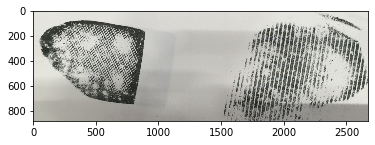

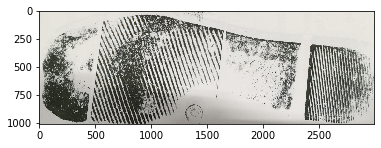

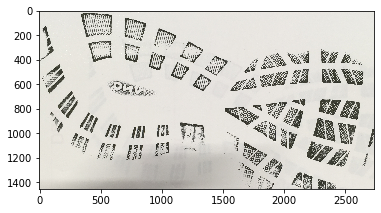

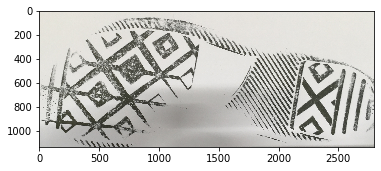

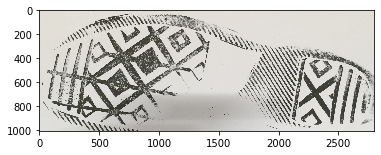

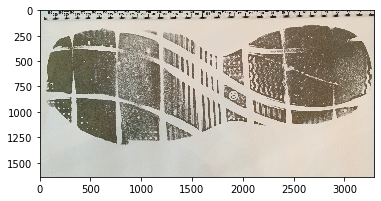

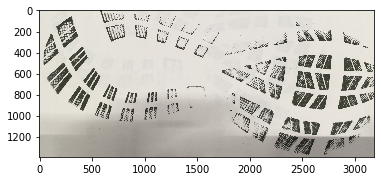

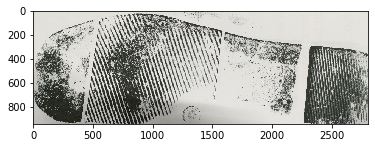

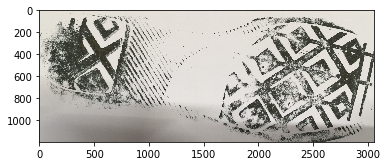

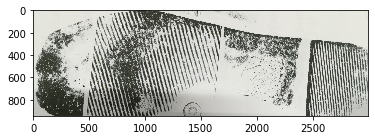

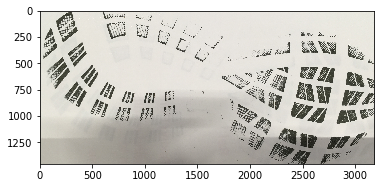

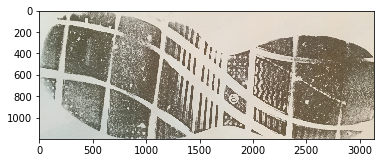

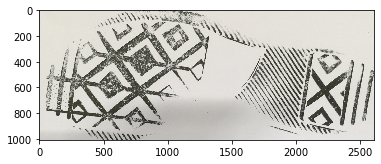

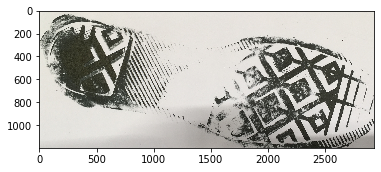

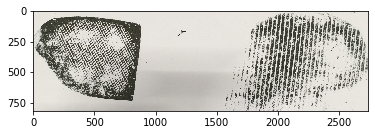

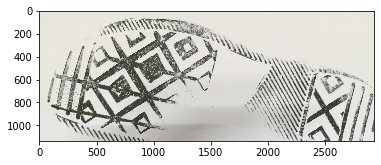

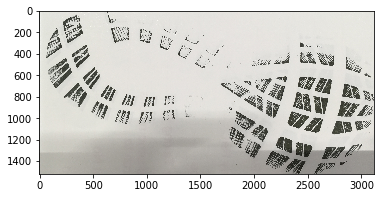

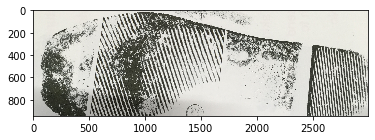

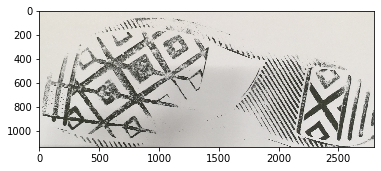

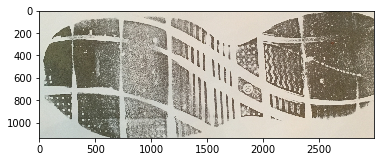

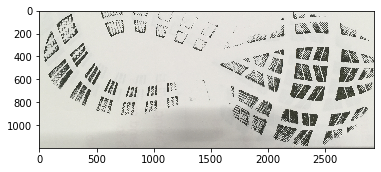

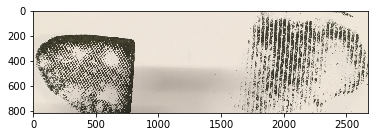

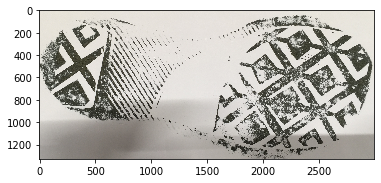

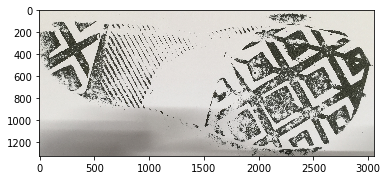

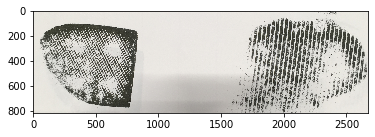

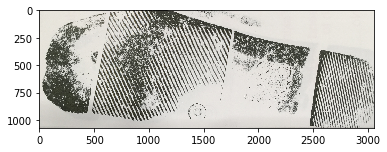

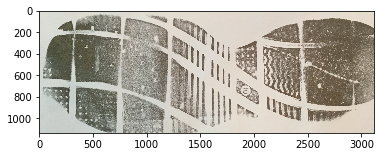

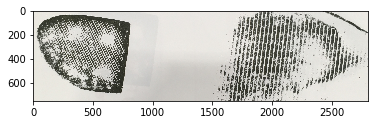

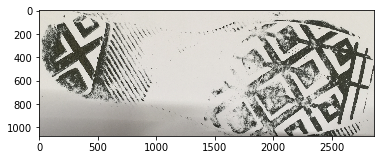

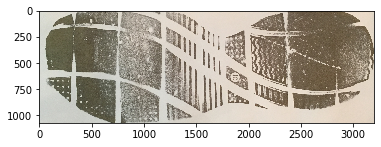

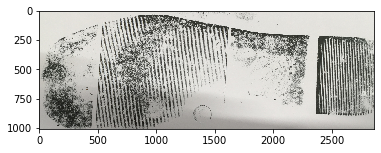

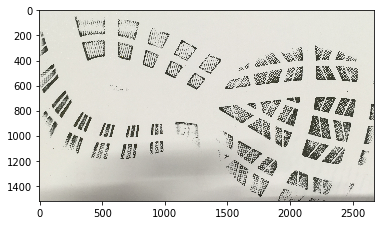

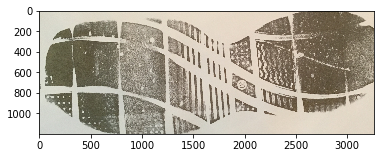

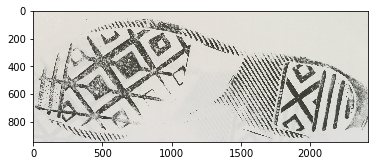

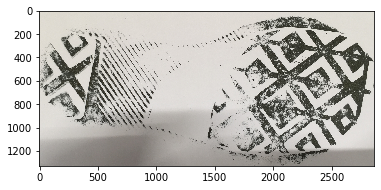

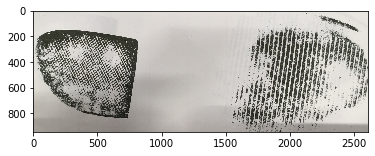

In [40]:
from PIL import Image

i = 0
for box in locations:
  img = Image.fromarray(ori[i])
  region = img.crop(box)
  tempname = './temp/cropped_'+str(i)+'.png'
  region.save(tempname)
  plt.figure()
  plt.imshow(plt.imread(tempname))
  i+=1

## increase image contrastion

In [0]:
from PIL import Image
from PIL import ImageEnhance

j = 0
for i in locations:
  img = Image.open('./temp/cropped_'+str(j)+'.png')
  #对比度增强  
  enh_con = ImageEnhance.Contrast(img)  
  contrast = 3
  img_contrasted = enh_con.enhance(contrast)  
  img_contrasted.show()
  img_contrasted.save('./cropped/'+str(j)+'.png')
  j+=1

## for presentation

### footwear selection (autoencoder)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


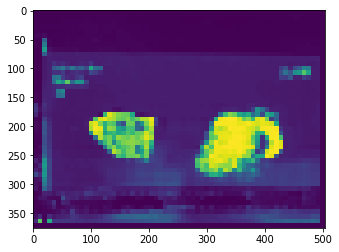

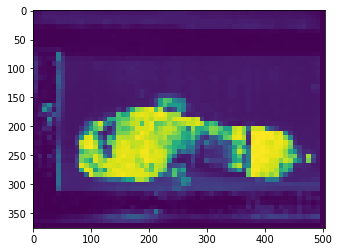

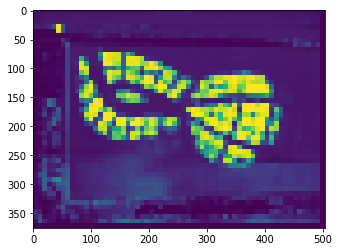

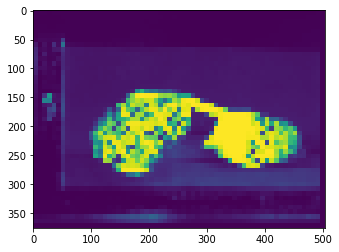

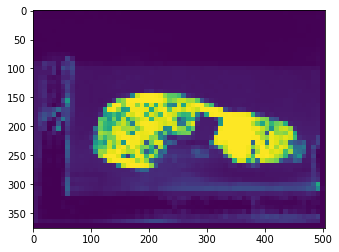

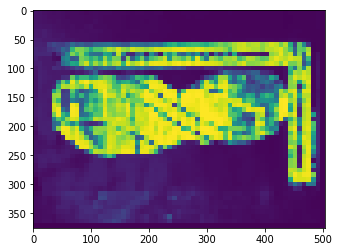

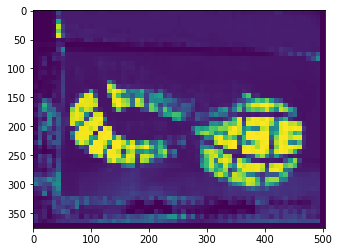

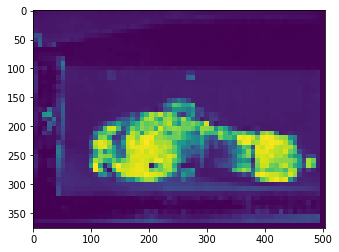

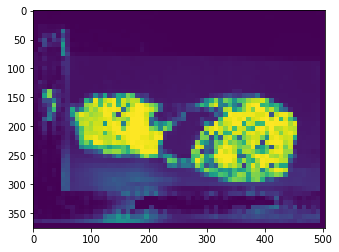

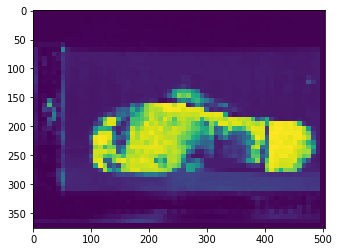

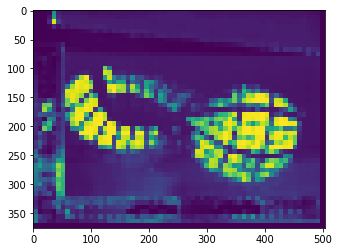

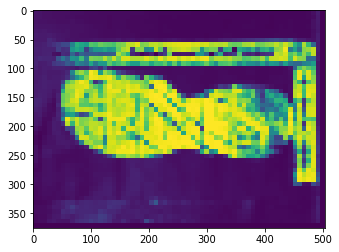

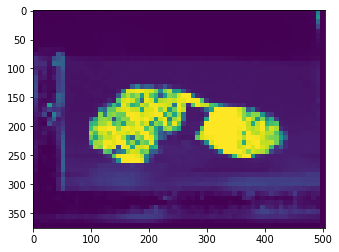

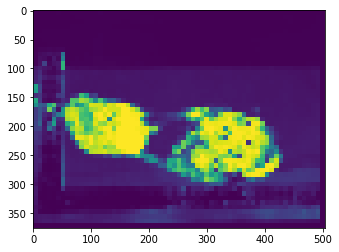

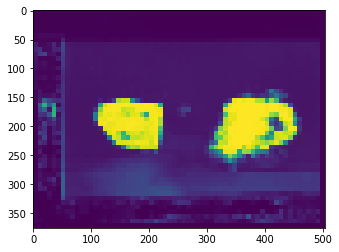

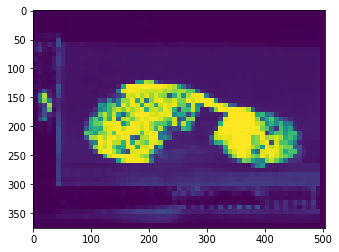

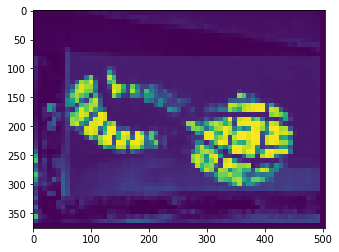

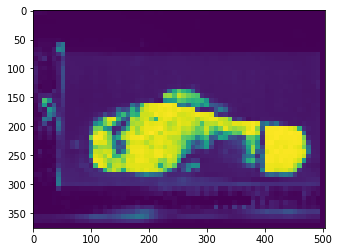

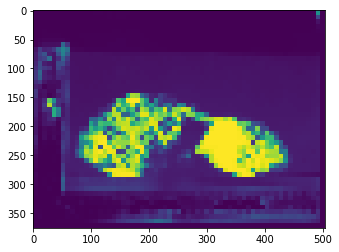

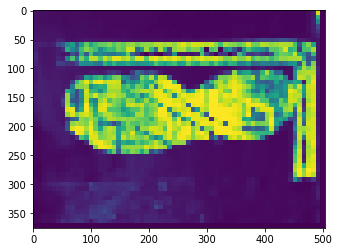

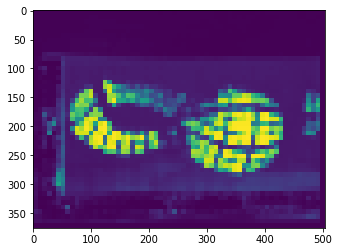

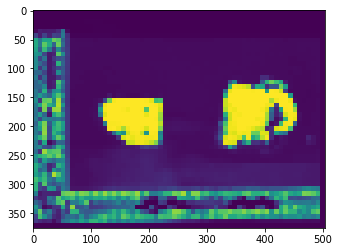

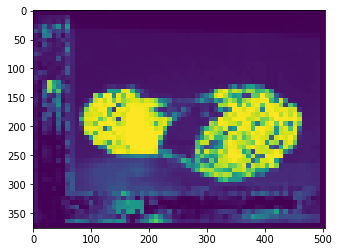

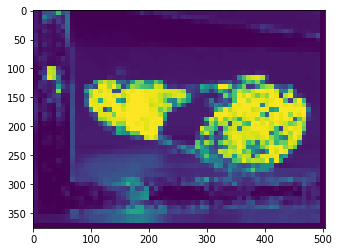

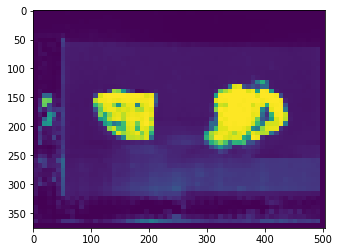

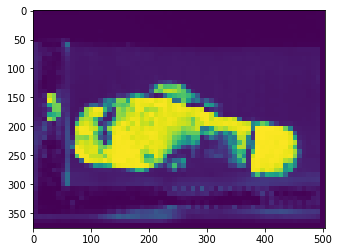

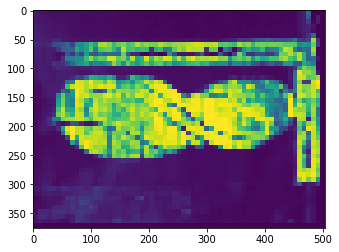

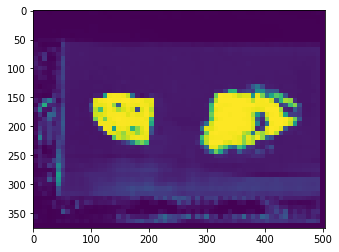

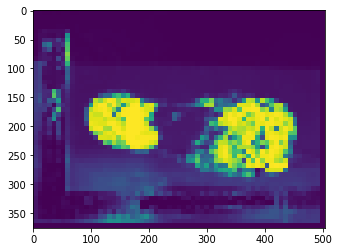

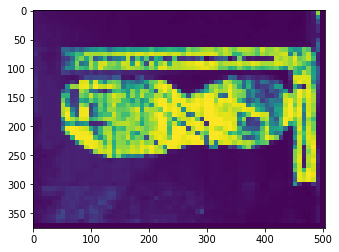

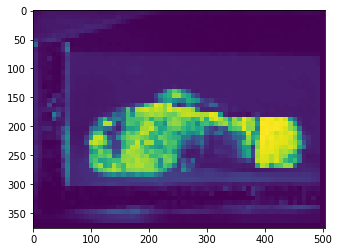

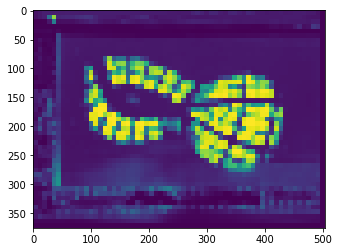

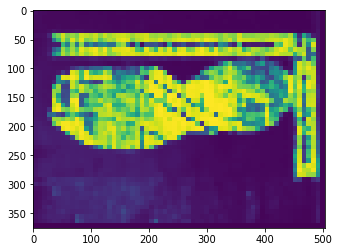

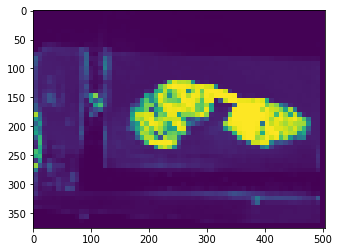

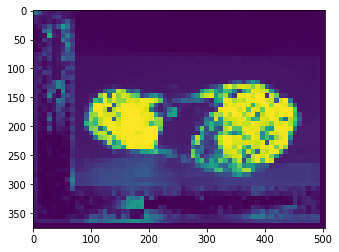

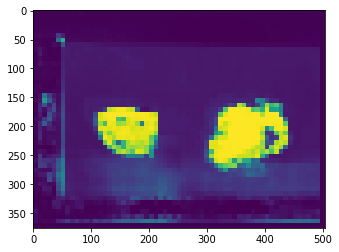

In [53]:
for i in  predictions_footwear_img:
  plt.figure()
  plt.imshow(i)

### selected area

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


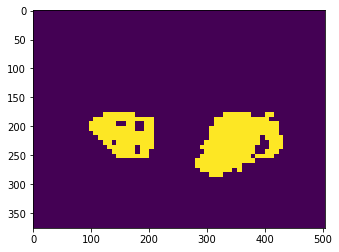

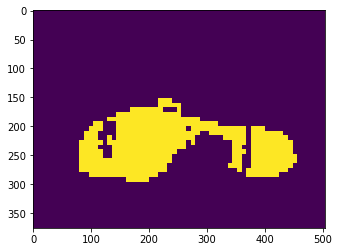

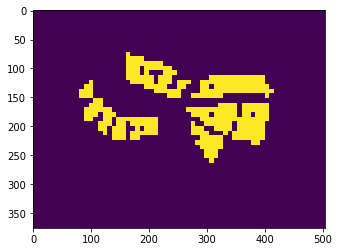

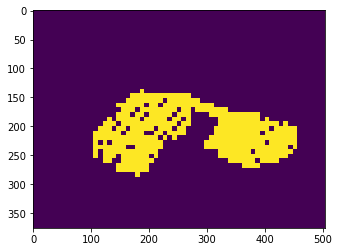

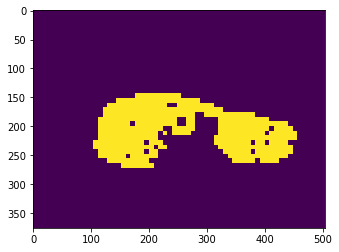

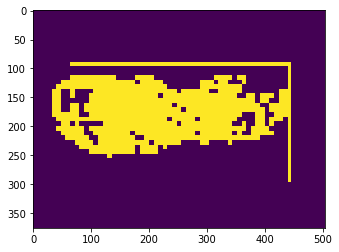

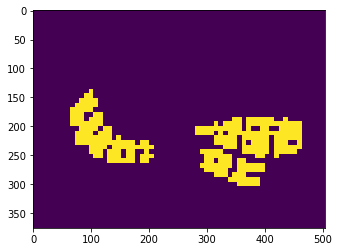

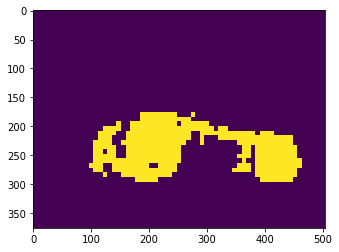

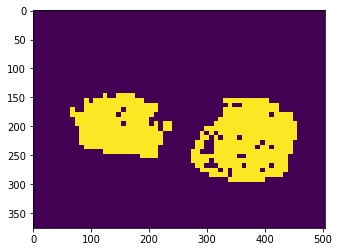

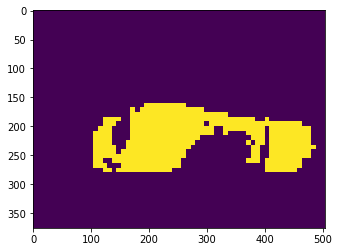

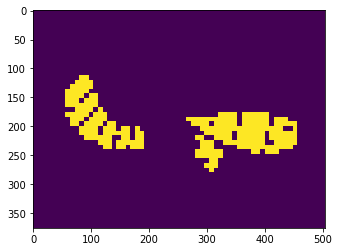

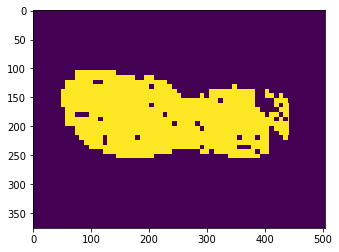

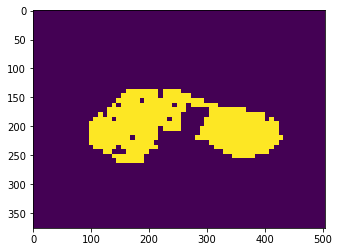

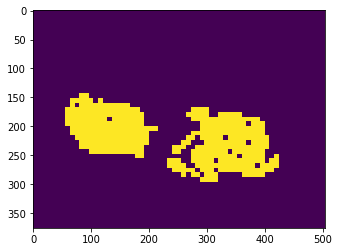

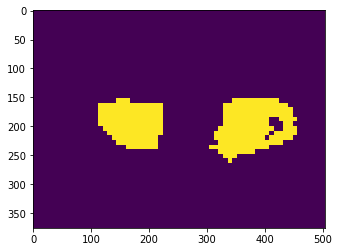

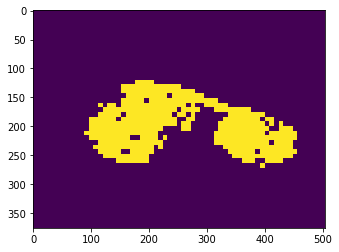

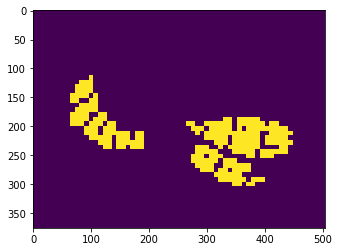

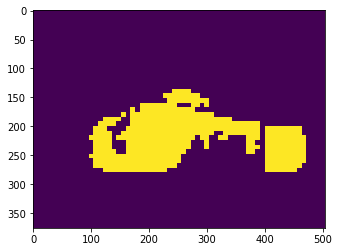

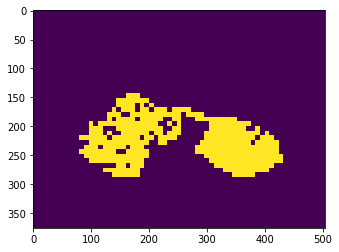

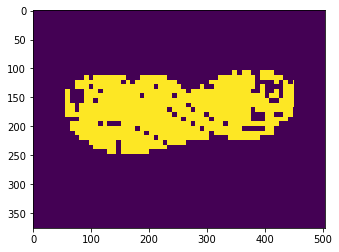

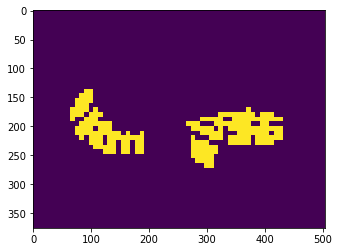

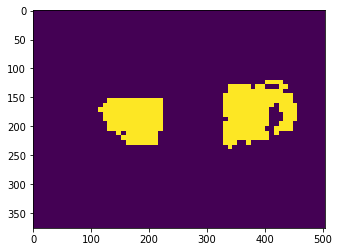

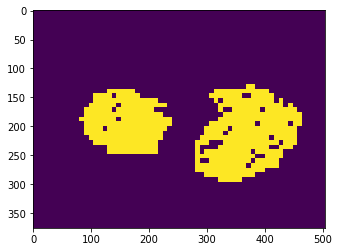

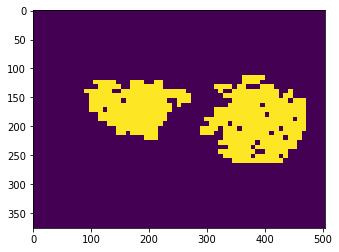

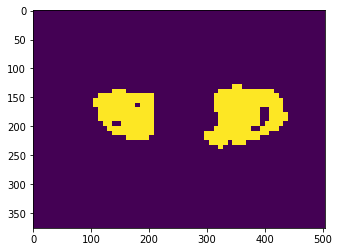

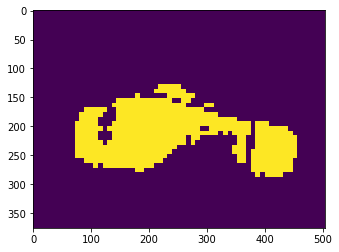

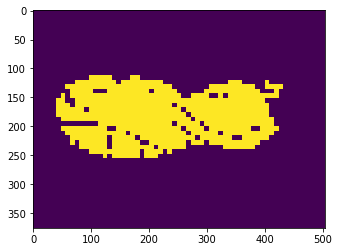

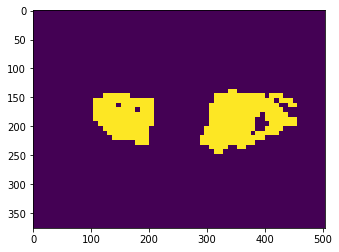

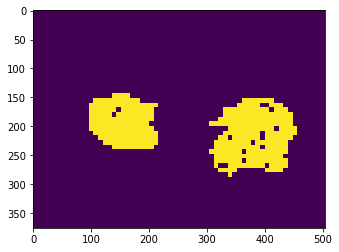

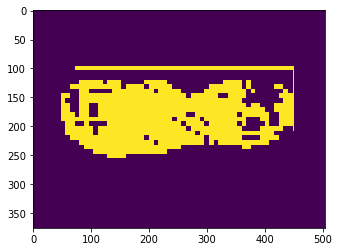

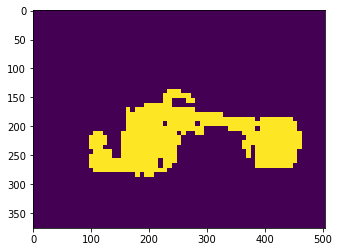

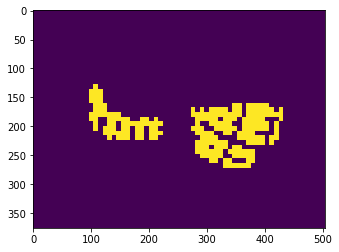

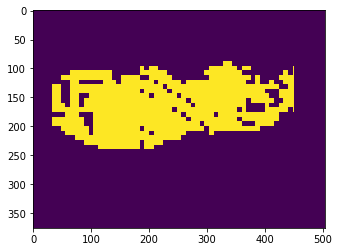

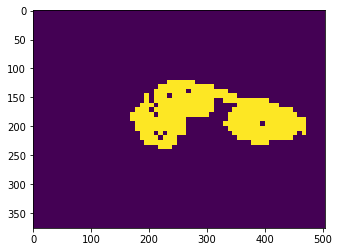

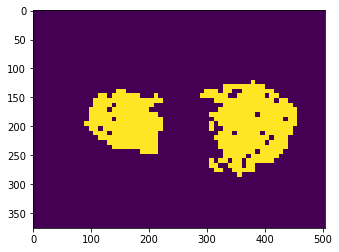

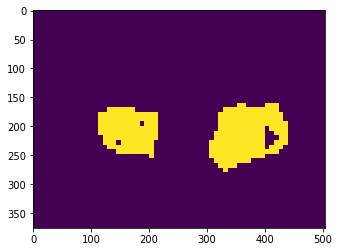

In [58]:
for i in range(len(predictions_footwear_img)):
  plt.figure()
  plt.imshow(selected_areas_k[i])

### ruler selection

yes this should be the marker
331.5 259.5
yes this should be the marker
339.5 263.5
yes this should be the marker
347.5 295.5
yes this should be the marker
339.5 279.5
yes this should be the marker
339.5 271.5
yes this should be the marker
75.5 255.5
yes this should be the marker
347.5 275.5
yes this should be the marker
339.5 259.5
yes this should be the marker
339.5 299.5
yes this should be the marker
339.5 275.5
yes this should be the marker
347.5 283.5
yes this should be the marker
75.5 259.5
yes this should be the marker
331.5 259.5
yes this should be the marker
331.5 263.5
yes this should be the marker
347.5 303.5
yes this should be the marker
331.5 275.5
yes this should be the marker
339.5 279.5
yes this should be the marker
331.5 267.5
yes this should be the marker
339.5 283.5
yes this should be the marker
75.5 267.5
yes this should be the marker
339.5 259.5
yes this should be the marker
339.5 303.5
something wrong, trying to fix it
[296 297 298 299 300 301 302 303 304 305 306 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


yes this should be the marker
347.5 291.5
yes this should be the marker
331.5 283.5
something wrong, trying to fix it
[240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288]
75.5 264.0
yes this should be the marker
347.5 283.5
yes this should be the marker
331.5 303.5
yes this should be the marker
83.5 267.5
yes this should be the marker
323.5 275.5
yes this should be the marker
331.5 279.5
yes this should be the marker
59.5 259.5
yes this should be the marker
299.5 303.5
yes this should be the marker
331.5 323.5
yes this should be the marker
347.5 287.5


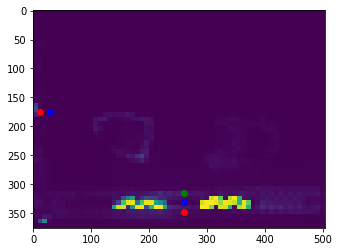

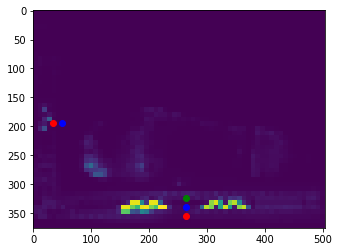

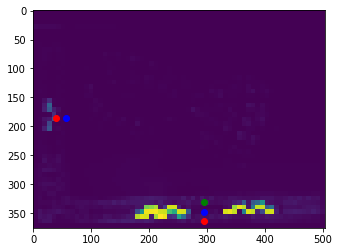

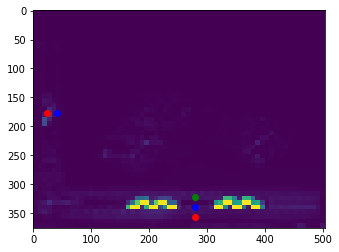

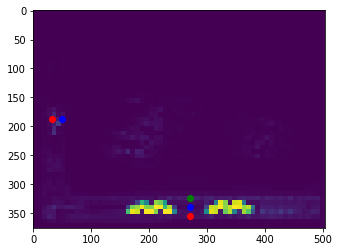

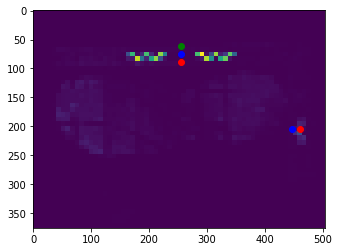

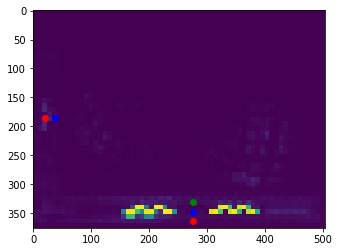

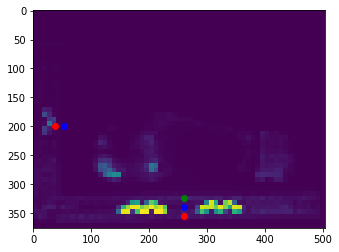

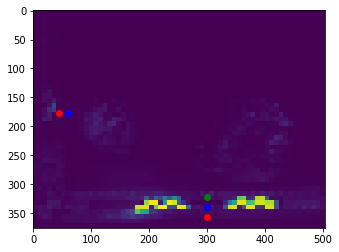

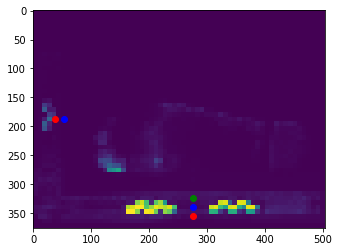

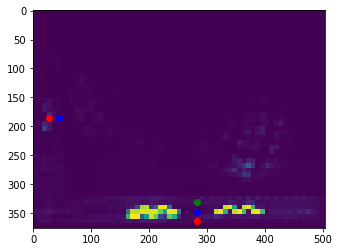

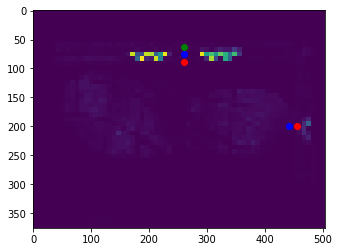

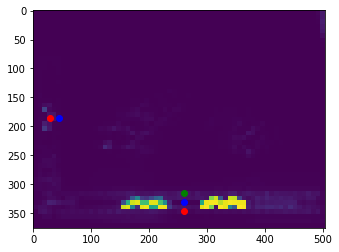

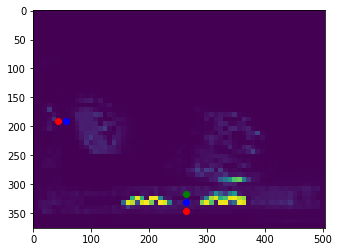

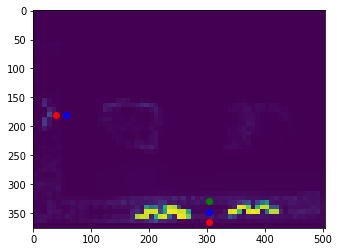

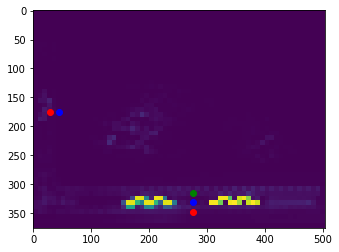

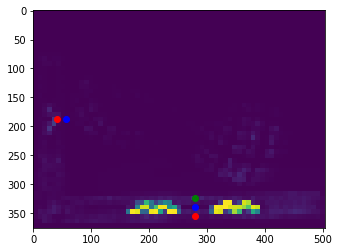

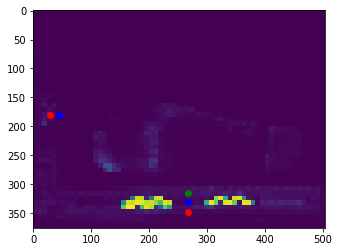

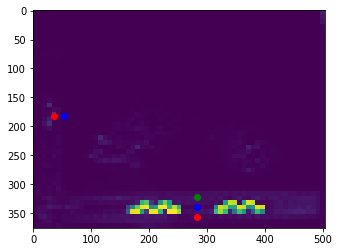

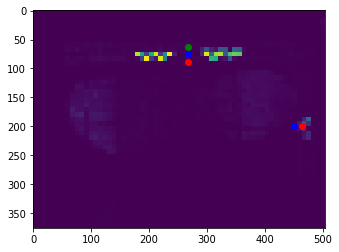

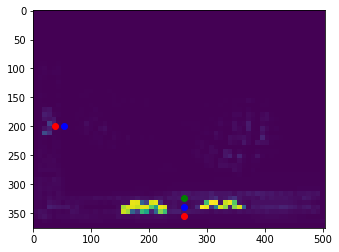

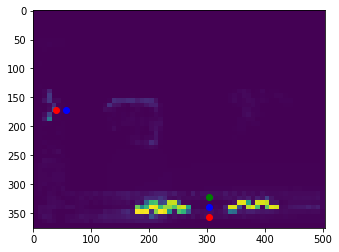

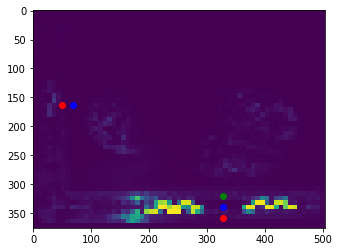

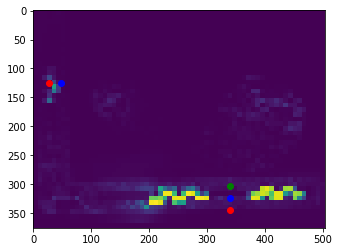

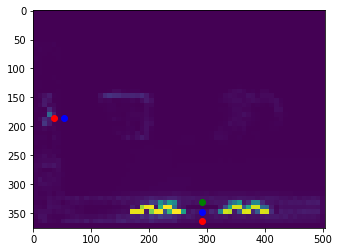

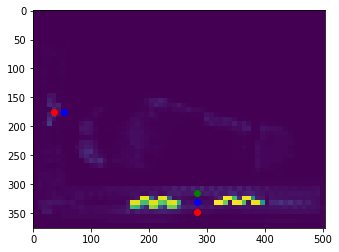

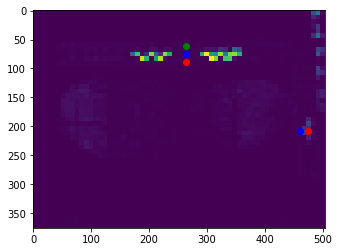

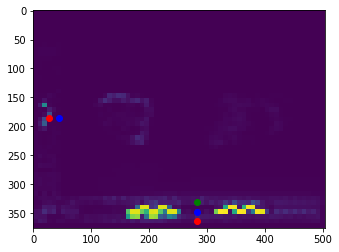

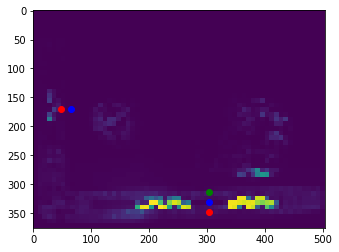

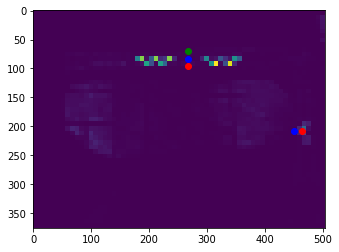

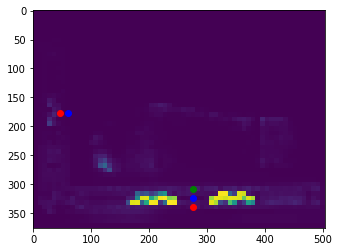

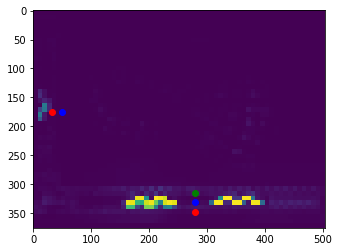

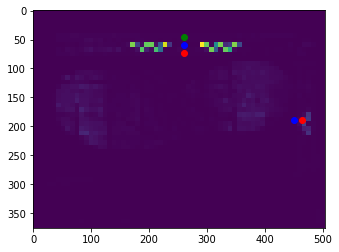

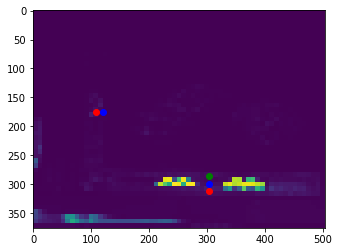

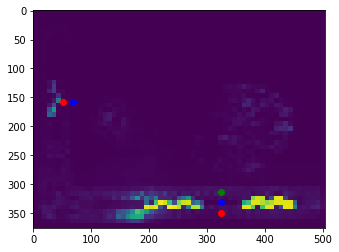

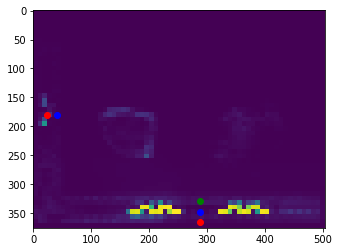

In [56]:
# fixed version
for i in range(0,len(predictions_bw_img)):
  # plt.figure()
  # plt.imshow(images[i])
  find_loc = sum(predictions_bw_img[i].T)
  locations = np.where(find_loc >= max(find_loc))
  # col_start to col_end should be the marker 
  col_start = min(locations[0]) - 5
  col_end = max(locations[0]) + 5
    # plt.plot(sum(predictions_bw_img[i][col_start:col_end]))
  selected_marker_row = sum(predictions_bw_img[i][col_start:col_end])
  mean = np.mean(selected_marker_row)
  two_marker_loc = np.where(selected_marker_row>=mean)[0]
  # 两个连续的数列
  marker = range(min(two_marker_loc),max(two_marker_loc)+1)
  med = list(set(marker)-set(two_marker_loc))
  if len(med) == len(list(range(min(med),max(med)+1))):
    print("yes this should be the marker")
    maker_center = np.median(med)
    maker_length = max(two_marker_loc) - min(two_marker_loc)
    maker_width = maker_length/14
  # plt.plot(sum(predictions_bw_img[i][col_start:col_end]))
    print(np.median(locations),maker_center)
    plt.figure()
    plt.imshow(predictions_bw_img[i])
    plt.plot(maker_center,np.median(locations[0]),'bo')
    plt.plot(maker_center,np.median(locations[0])+maker_width,'ro')
    plt.plot(maker_center,np.median(locations[0])-maker_width,'go')
  else:
    print("something wrong, trying to fix it")
    selected_marker_row[selected_marker_row>np.mean(selected_marker_row)]=1
    selected_marker_row[selected_marker_row!=1] = 0
    sum_bag = test(list(selected_marker_row))
    center_pixels = np.where(np.abs(sum_bag) == max(np.abs(sum_bag)))[0]
    print(center_pixels)
    maker_center = np.median(center_pixels)
    maker_length = len(center_pixels)*4
    maker_width = maker_length/14

    print(np.median(locations),maker_center)
    plt.figure()
    plt.imshow(predictions_bw_img[i])
    plt.plot(maker_center,np.median(locations[0]),'bo')
    plt.plot(maker_center,np.median(locations[0])+maker_width,'ro')
    plt.plot(maker_center,np.median(locations[0])-maker_width,'go')
  if np.median(locations[0])>376/2:
    # 在下就在左边
    try:
      plt.plot(maker_center-maker_length/140*150,np.median(locations[0])-maker_width-maker_length/140*85,'ro')
      plt.plot(maker_center-maker_length/140*150+maker_width,np.median(locations[0])-maker_width-maker_length/140*85,'bo')
    except:
      print(maker_center-maker_length/140*150+maker_width,np.median(locations[0])-maker_width-maker_length/140*85)
  else:
    # 在上就在右边
    try:
      plt.plot(maker_center+maker_length/140*150,np.median(locations[0])+maker_width+maker_length/140*85,'ro')
      plt.plot(maker_center+maker_length/140*150-maker_width,np.median(locations[0])+maker_width+maker_length/140*85,'bo')
    except:
      print(maker_center+maker_length/140*150-maker_width,np.median(locations[0])+maker_width+maker_length/140*85)
